## Example 03 - Defining a basic simulation

### Imports
Import the required libraries

In [17]:
# package(s) related to time, space and id
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# tranport network analysis package
import transport_network_analysis.core as core

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

### Create graph

The cel below visualizes the problem. In graph theory the red dots are called *edges* and the lines are called *vertices*. Vessels (or any other object) move from edge 1 to edge 3 and from edge 4 to edge 2. The added complexity is that vertice 5-6 only allows traffic in one direction at a time. Vessels can travel simultanously in one direction.

In [18]:
Node = type('Site', (core.Identifiable, core.Log, core.Locatable, core.HasResource), {})

data_node_1 = {"env": [],
               "name": "Node 1",
               "geometry": shapely.geometry.Point(0, 0)}
data_node_2 = {"env": [],
               "name": "Node 2",
               "geometry": shapely.geometry.Point(0, 10)}
data_node_3 = {"env": [],
               "name": "Node 3",
               "geometry": shapely.geometry.Point(10, 10)}
data_node_4 = {"env": [],
               "name": "Node 4",
               "geometry": shapely.geometry.Point(10, 0)}

node_1 = Node(**data_node_1)
node_2 = Node(**data_node_2)
node_3 = Node(**data_node_3)
node_4 = Node(**data_node_4)

nodes = [node_1, node_2, node_3, node_4]

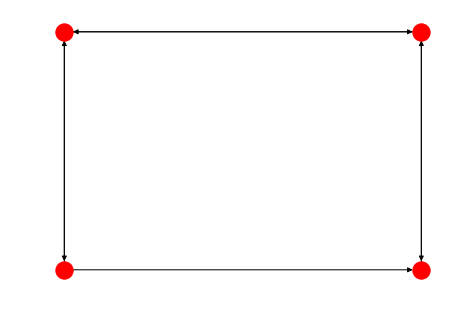

In [19]:
FG = nx.DiGraph()

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

path = [[node_1, node_2], # From node 1 to node 2
        [node_1, node_4], # From node 1 to node 4
        [node_2, node_1], # From node 2 to node 1
        [node_2, node_3], # From node 2 to node 3
        [node_3, node_2], # From node 3 to node 2
        [node_3, node_4], # From node 3 to node 4
        [node_4, node_3]] # From node 4 to node 3 - So one-way traffic is from node 1 to node 4

for edge in path:
    FG.add_edge(edge[0].name, edge[1].name, weight = 1)

nx.draw(FG, positions)
plt.show()

In [20]:
# To show that moving from Node 4 to Node 1 is not possible
print("From 1 to 4:", nx.shortest_path_length(FG, "Node 1", "Node 4"))
print("From 4 to 1:", nx.shortest_path_length(FG, "Node 4", "Node 1"))

From 1 to 4: 1
From 4 to 1: 3


### Create vessels
Vessel without graph, but with shortest path.

In [21]:
# Make a class out of mix-ins
TransportResource = type('TransportResource', 
                         (core.Identifiable, core.Log, core.ContainerDependentMovable, 
                          core.HasResource, core.Routeable), {})



# For testing purposes we only want v to be 1
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

data_vessel = {"env": None,
               "name": "Vessel number 1",
               "route": None,
               "geometry": shapely.geometry.Point(0, 0),  # lon, lat
               "capacity": 1_000,
               "compute_v": compute_v_provider(v_empty=1, v_full=1)}

# create the transport processing resource
vessel = TransportResource(**data_vessel)

### Define paths

In [22]:
# First simulation is from Node 1 to Node 4
path_1 = nx.dijkstra_path(FG, node_1.name, node_4.name)

# Second simulation is from Node 4 to Node 1
path_2 = nx.dijkstra_path(FG, node_4.name, node_1.name)

paths = [path_1, path_2]

### Run simulation

In [23]:
def start(env, vessel):
    while True:
        vessel.log_entry("Start sailing", env.now, "", vessel.geometry)
        yield from vessel.move()
        vessel.log_entry("Stop sailing", env.now, "", vessel.geometry)
        
        if vessel.geometry == nx.get_node_attributes(FG, "geometry")[vessel.route[-1]]:
            break

In [24]:
for path in enumerate(paths):
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())
    
    # Add graph to environment
    env.FG = FG
    
    # Add environment and path to the vessel
    vessel.env = env
    vessel.route = path[1]

    # Start the simulation
    env.process(start(env, vessel))
    env.run()

    print("Simulation of path {} took {} seconds".format(path[0] + 1, int(env.now)))

Simulation of path 1 took 1550936243 seconds
Simulation of path 2 took 1553131110 seconds


### Testing

In [25]:
for geo in vessel.log["Geometry"]:
    print(geo.x, geo.y)

0.0 0.0
0.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 10.0
10.0 10.0
0.0 10.0
0.0 10.0
0.0 0.0
0.0 0.0


In [26]:
vessel.log["Timestamp"]

[datetime.datetime(2019, 2, 10, 19, 24, 9),
 datetime.datetime(2019, 2, 10, 19, 24, 9),
 datetime.datetime(2019, 2, 23, 16, 37, 23, 907933),
 datetime.datetime(2019, 2, 23, 16, 37, 23, 907933),
 datetime.datetime(2019, 2, 10, 19, 24, 9),
 datetime.datetime(2019, 2, 10, 19, 24, 9),
 datetime.datetime(2019, 2, 23, 14, 35, 3, 833234),
 datetime.datetime(2019, 2, 23, 14, 35, 3, 833234),
 datetime.datetime(2019, 3, 8, 7, 7, 35, 387803),
 datetime.datetime(2019, 3, 8, 7, 7, 35, 387803),
 datetime.datetime(2019, 3, 21, 2, 18, 30, 221038),
 datetime.datetime(2019, 3, 21, 2, 18, 30, 221038)]

In [27]:
wgs84 = pyproj.Geod(ellps='WGS84')
distance_path_1 = 0
distance_path_2 = 0

for node in enumerate(path_1):
    orig = nx.get_node_attributes(FG, "geometry")[path_1[node[0]]]
    dest = nx.get_node_attributes(FG, "geometry")[path_1[node[0] + 1]]

    distance_path_1 += int(wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y, 
                                     shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2])
    
    if node[0] + 2 == len(path_1):
                break

for node in enumerate(path_2):
    orig = nx.get_node_attributes(FG, "geometry")[path_2[node[0]]]
    dest = nx.get_node_attributes(FG, "geometry")[path_2[node[0] + 1]]

    distance_path_2 += int(wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y, 
                                     shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2])
    
    if node[0] + 2 == len(path_2):
                break